In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Task 1

In [37]:
noisysine_data = np.array(pd.read_csv("../Datasets/noisysine.csv"))
hydrodynamics_data = np.array(pd.read_csv("../Datasets/hydrodynamics.csv"))
from warnings import filterwarnings
filterwarnings('ignore')

In [3]:
def divide_xy(data):
    x_data = data[:, 0:-1]
    y_data = data[:, -1]
    return (x_data, y_data)

noisysine_x, noisysine_y = divide_xy(noisysine_data)
hydrodynamics_x, hydrodynamics_y = divide_xy(hydrodynamics_data)

In [4]:
from sklearn.model_selection import train_test_split
noisysine_train_x, noisysine_valid_x, noisysine_train_y, noisysine_valid_y = train_test_split(noisysine_x, noisysine_y, test_size=0.2)
hydrodynamics_train_x, hydrodynamics_valid_x, hydrodynamics_train_y, hydrodynamics_valid_y = train_test_split(hydrodynamics_x, hydrodynamics_y, test_size=0.2)

In [40]:
def r2_score(true_y, pred_y):
    u = sum([(true_y[i] - pred_y[i]) ** 2 for i in range(len(true_y))])
    mean_y = sum(true_y) / len(true_y)
    v = sum([(true_y[i] - mean_y) ** 2 for i in range(len(true_y))])
    return 1.0 - u / v

def show_curve(data_x, data_y, predict):
    plt.scatter(data_x, data_y, color='red')
    
    x_min = 0
    x_max = 40
    step = 0.01
    
    x = x_min
    
    xs = []
    xxs = []
    
    while (x < x_max):
        xs.append(x)
        xxs.append([x])
        x += step
    ys = predict(np.array(xxs))
    
    plt.plot(xs, ys)
    plt.show()
    plt.close()

def linear_regression(data_x, data_y):
    w = np.linalg.inv(data_x.T @ data_x) @ data_x.T @ data_y
    return lambda x: x @ w

from sklearn.preprocessing import PolynomialFeatures

def polynomial_features(xs, degree):
    return PolynomialFeatures(degree).fit_transform(xs)

In [21]:
def regression(train_x, train_y, degree):
    train_x = polynomial_features(train_x, degree)
    return lambda x: linear_regression(train_x, train_y)(polynomial_features(x, degree))

noisysine dataset:
For degree=1 r2_score=0.13209869339093916


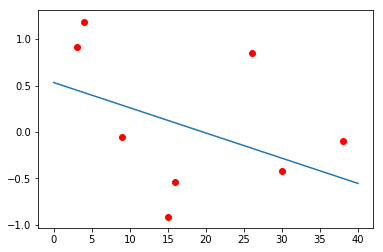

For degree=2 r2_score=0.06917055197401323


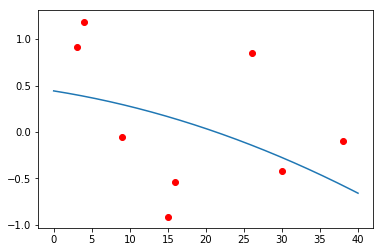

For degree=3 r2_score=0.1822981090236524


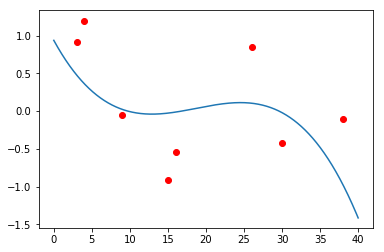

For degree=4 r2_score=0.1374758079375562


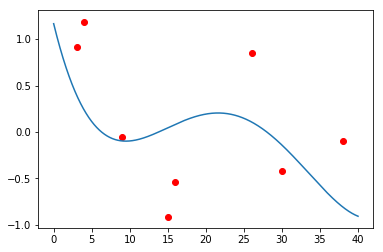

For degree=5 r2_score=0.8687646870332901


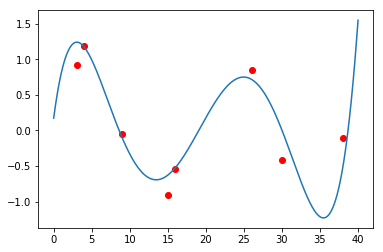

In [22]:
print("noisysine dataset:")
for degree in [1, 2, 3, 4, 5]:
    predict = regression(noisysine_train_x, noisysine_train_y, degree)
    pred_y = predict(noisysine_valid_x)
    print("For degree="+str(degree)+" r2_score=" + str(r2_score(noisysine_valid_y, pred_y)))
    show_curve(noisysine_valid_x, noisysine_valid_y, predict)

In [24]:
print("hydrodynamics dataset:")
for degree in [1, 2]:
    predict = regression(hydrodynamics_train_x, hydrodynamics_train_y, degree)
    pred_y = predict(hydrodynamics_valid_x)
    print("For degree="+str(degree)+" r2_score=" + str(r2_score(hydrodynamics_valid_y, pred_y)))

hydrodynamics dataset:
For degree=1 r2_score=0.6637846088531235
For degree=2 r2_score=0.9294550197780436


# Task 2

In [25]:
def ridge_regression(data_x, data_y, alpha):
    w = np.linalg.inv(data_x.T @ data_x + alpha * np.identity(data_x.shape[1])) @ data_x.T @ data_y
    return lambda x: x @ w

def regression(train_x, train_y, valid_x, valid_y, degree):
    train_x = polynomial_features(train_x, degree)
    valid_x = polynomial_features(valid_x, degree)
    alphas = [0.1 ** i for i in range(10)]
    scores = []
    for i in range(len(alphas)):
        pred_y = ridge_regression(train_x, train_y, alphas[i])(valid_x)
        scores.append(r2_score(valid_y, pred_y))
    scores = np.array(scores)
    return (lambda x: ridge_regression(train_x, train_y, alphas[scores.argmax()])(polynomial_features(x, degree)), alphas[scores.argmax()])

noisysine dataset:
For degree=1 r2_score=0.13209869339088653
best alpha=1.0000000000000005e-09


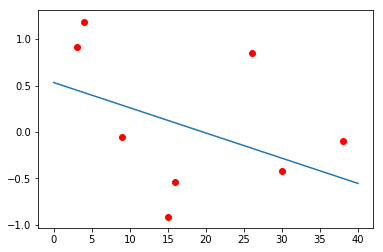

For degree=2 r2_score=0.06917055192941302
best alpha=1.0000000000000005e-09


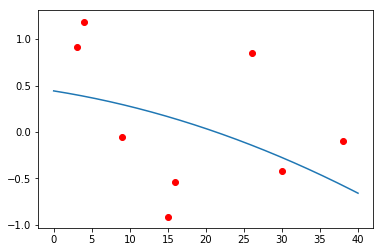

For degree=3 r2_score=0.18229810890182963
best alpha=1.0000000000000005e-09


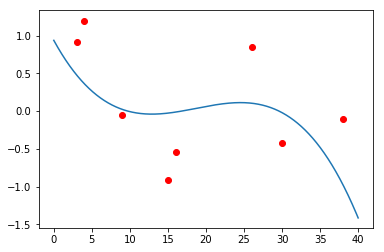

For degree=4 r2_score=0.137475807791004
best alpha=1.0000000000000005e-09


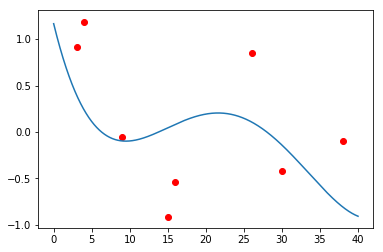

For degree=5 r2_score=0.8693422183293397
best alpha=0.1


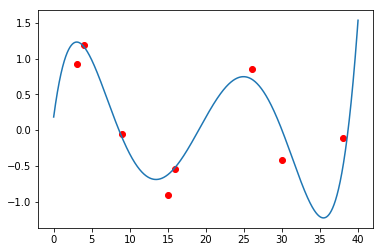

In [27]:
print("noisysine dataset:")
for degree in [1, 2, 3, 4, 5]:
    predict, alpha = regression(noisysine_train_x, noisysine_train_y, noisysine_valid_x, noisysine_valid_y, degree)
    pred_y = predict(noisysine_valid_x)
    print("For degree="+str(degree)+" r2_score=" + str(r2_score(noisysine_valid_y, pred_y)))
    print("best alpha=" + str(alpha))
    show_curve(noisysine_valid_x, noisysine_valid_y, predict)

In [54]:
print("hydrodynamics dataset:")
for degree in [1, 2]:
    pred_y, alpha = regression(hydrodynamics_train_x, hydrodynamics_train_y, hydrodynamics_valid_x, hydrodynamics_valid_y, degree)
    print("For degree="+str(degree)+" r2_score=" + str(r2_score(hydrodynamics_valid_y, pred_y)))
    print("best alpha=" + str(alpha))

hydrodynamics dataset:
For degree=1 r2_score=0.6083128711381738
best alpha=0.1
For degree=2 r2_score=0.9190571979948386
best alpha=0.0010000000000000002


# Task 3

In [38]:
from sklearn import linear_model

def lasso_regression(data_x, data_y, alpha):
    model = linear_model.Lasso(alpha=alpha, max_iter=5e4)
    model.fit(data_x, data_y)
    return lambda xs: model.predict(xs)

def lasso_regression_features(data_x, data_y, alpha):
    model = linear_model.Lasso(alpha=alpha, max_iter=5e4)
    model.fit(data_x, data_y)
    return sum(map(lambda x: 0 if (x == 0) else 1, model.coef_))

def regression(train_x, train_y, valid_x, valid_y, degree):
    train_x = polynomial_features(train_x, degree)
    valid_x = polynomial_features(valid_x, degree)
    alphas = [0.1 ** i for i in range(8)]
    scores = []
    for i in range(len(alphas)):
        predict = lasso_regression(train_x, train_y, alphas[i])
        pred_y = predict(valid_x)
        scores.append(r2_score(valid_y, pred_y))
    scores = np.array(scores)
    return (lambda xs: lasso_regression(train_x, train_y, alphas[scores.argmax()])(polynomial_features(xs, degree)), alphas[scores.argmax()], lasso_regression_features(train_x, train_y, alphas[scores.argmax()]))

noisysine dataset:
For degree=1 r2_score=0.13313360435357924
best alpha=0.1
used features=1


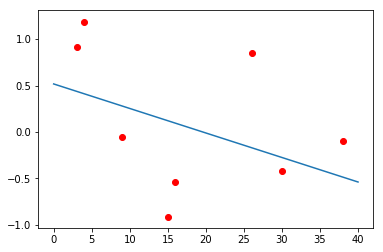

For degree=2 r2_score=0.0691994631664048
best alpha=0.00010000000000000002
used features=2


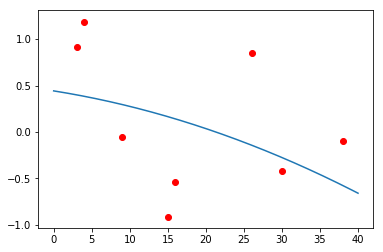

For degree=3 r2_score=0.18223627968362788
best alpha=0.00010000000000000002
used features=3


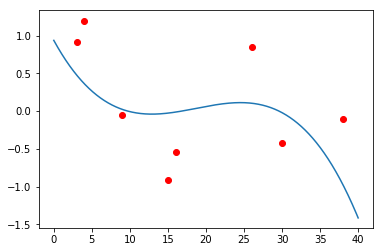

For degree=4 r2_score=0.13784917276323905
best alpha=0.00010000000000000002
used features=4


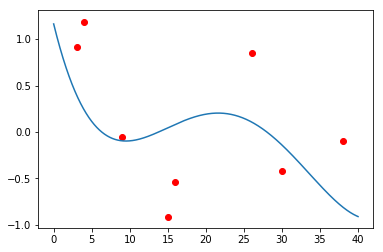

For degree=5 r2_score=0.3867284811960564
best alpha=0.1
used features=5


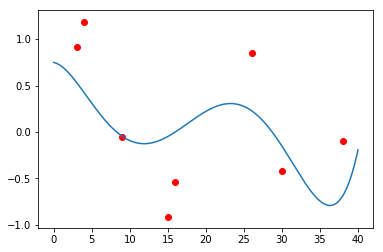

In [41]:
print("noisysine dataset:")
for degree in [1, 2, 3, 4, 5]:
    predict, alpha, features = regression(noisysine_train_x, noisysine_train_y, noisysine_valid_x, noisysine_valid_y, degree)
    pred_y = predict(noisysine_valid_x)
    print("For degree="+str(degree)+" r2_score=" + str(r2_score(noisysine_valid_y, pred_y)))
    print("best alpha=" + str(alpha))
    print("used features=" + str(features))
    show_curve(noisysine_valid_x, noisysine_valid_y, predict)

In [42]:
print("hydrodynamics dataset:")
for degree in [1, 2]:
    predict, alpha, features = regression(hydrodynamics_train_x, hydrodynamics_train_y, hydrodynamics_valid_x, hydrodynamics_valid_y, degree)
    pred_y = predict(hydrodynamics_valid_x)
    print("For degree="+str(degree)+" r2_score=" + str(r2_score(hydrodynamics_valid_y, pred_y)))
    print("best alpha=" + str(alpha))
    print("used features=" + str(features))

hydrodynamics dataset:
For degree=1 r2_score=0.6670178527199975
best alpha=0.010000000000000002
used features=5
For degree=2 r2_score=0.9349371902273773
best alpha=0.00010000000000000002
used features=24
